In [31]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV


In [32]:
client = CryptoHistoricalDataClient()

In [33]:
request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD"],
  timeframe=TimeFrame.Day,
  start=datetime(2022, 9, 1),
  end=datetime(2026, 1, 1)
)

In [34]:
# Retrieve daily bars for Bitcoin in a DataFrame and printing it
btc_bars = client.get_crypto_bars(request_params)

# Convert to dataframe
btc_bars.df



open          high           low  \
symbol  timestamp                                                           
BTC/USD 2022-09-01 00:00:00+00:00  20051.8100  20205.830000  19564.860000   
        2022-09-02 00:00:00+00:00  20132.5000  20444.000000  19757.720000   
        2022-09-03 00:00:00+00:00  19950.6300  20054.690000  19658.040000   
        2022-09-04 00:00:00+00:00  19834.8700  20030.890000  19587.860000   
        2022-09-05 00:00:00+00:00  19998.7700  20058.000000  19635.960000   
...                                       ...           ...           ...   
        2025-12-28 00:00:00+00:00  87842.5000  89393.014310  87366.219000   
        2025-12-29 00:00:00+00:00  87898.1000  90315.655000  86699.507389   
        2025-12-30 00:00:00+00:00  87116.3370  89314.650761  86699.507389   
        2025-12-31 00:00:00+00:00  88400.9845  89090.400000  87074.155000   
        2026-01-01 00:00:00+00:00  87513.6405  88814.006000  87351.400000   

                                       close       volume  trade_count  \
symbol  timestamp                                                        
BTC/USD 2022-09-01 00:00:00+00:00  20132.970  7529.674053     114052.0   
        2022-09-02 00:00:00+00:00  19954.160  7392.679014      98745.0   
        2022-09-03 00:00:00+00:00  19832.060  3077.135497      52729.0   
        2022-09-04 00:00:00+00:00  20002.380  3712.178165      60722.0   
        2022-09-05 00:00:00+00:00  19795.120  4817.489036      66396.0   
...                                      ...          ...          ...   
        2025-12-28 00:00:00+00:00  87888.520     0.389592        249.0   
        2025-12-29 00:00:00+00:00  87122.985     1.241961        543.0   
        2025-12-30 00:00:00+00:00  88395.268     1.135230        364.0   
        2025-12-31 00:00:00+00:00  87488.274     2.651246        350.0   
        2026-01-01 00:00:00+00:00  88756.746     1.002217        300.0   

                                           vwap  
symbol  timestamp                                
BTC/USD 2022-09-01 00:00:00+00:00  19934.701556  
        2022-09-02 00:00:00+00:00  20095.899441  
        2022-09-03 00:00:00+00:00  19839.406563  
        2022-09-04 00:00:00+00:00  19813.537532  
        2022-09-05 00:00:00+00:00  19801.578592  
...                                         ...  
        2025-12-28 00:00:00+00:00  87683.575698  
        2025-12-29 00:00:00+00:00  88195.762648  
        2025-12-30 00:00:00+00:00  87994.628522  
        2025-12-31 00:00:00+00:00  88195.622717  
        2026-01-01 00:00:00+00:00  87837.000919  

[1219 rows x 7 columns]

In [38]:

# Prepare dataframe
df = btc_bars.df.reset_index()
df = df[df["symbol"] == "BTC/USD"].copy()

# Target: next day's closing price
df["target"] = df["close"].shift(-1)
df.dropna(inplace=True)

features = [
    "open",
    "volume",
    "high",
    "low",
    "trade_count",
]

X = df[features]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

cv = 3  # folds

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid={'n_estimators': range(50, 300, 50), 'max_depth': [None, 5, 9, 12]},
    cv=cv, scoring='r2', n_jobs=-1
)
rf_grid.fit(X_train, y_train)
print(f"RF best params: {rf_grid.best_params_}  CV R²={rf_grid.best_score_:.4f}")

best_rf = RandomForestRegressor(n_estimators=250, max_depth=None)
best_rf.fit(X_train, y_train)
predictions = best_rf.predict(X_test)


RF best params: {'max_depth': None, 'n_estimators': 250}  CV R²=0.1891


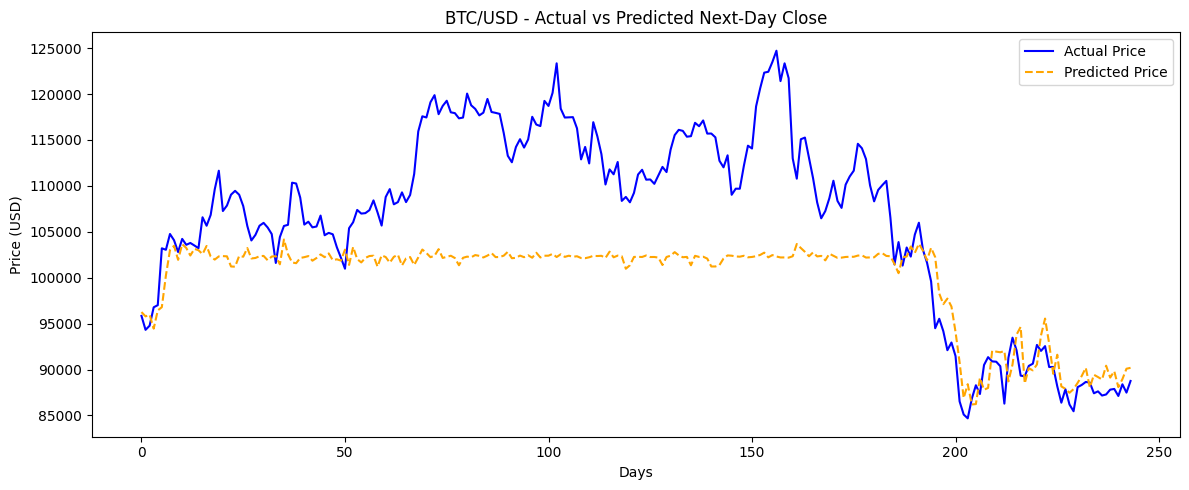

In [36]:

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label="Actual Price", color="blue")
plt.plot(predictions, label="Predicted Price", color="orange", linestyle="--")
plt.title("BTC/USD - Actual vs Predicted Next-Day Close")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
# Feature importance
importances = pd.Series(best_rf.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importances:")
print(importances)



Feature Importances:
high           0.492751
low            0.266126
open           0.240040
volume         0.000554
trade_count    0.000529
dtype: float64


In [40]:
from sklearn.ensemble import GradientBoostingRegressor

# == 5. Gradient Boosting ==============================================================
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid={
        'n_estimators': range(50, 500, 50),
        'max_depth':    [None, 5, 7, 11, 15],
        'min_samples_split': range(2, 5)
    },
    cv=cv, scoring='r2', n_jobs=-1
)
gb_grid.fit(X_train, y_train)
print(f"GradBoost best params: {gb_grid.best_params_}  CV R²={gb_grid.best_score_:.4f}")

GradBoost best params: {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 150}  CV R²=0.2045
